In [1]:
"""
2025-02-13 MY
Query PAITULI STAC to find S2 L2A.

Calculate Daily NDVI Time-Series from Sentinel-2 Imagery Using STAC

Large BBOX.

"""
import numpy as np
import stackstac
from dask.distributed import Client, Lock
import pystac_client
import pyproj
import geopandas as gpd
import json
import requests
import os
from pathlib import Path
import rioxarray
import re
import pandas as pd
from datetime import datetime

        
import xarray as xr

import matplotlib.pyplot as plt

FILTER_OUT_SEN2COR_CLASSES = [0, 1, 3, 8, 9, 10]

# Make a bitmask
mask_bitfields = FILTER_OUT_SEN2COR_CLASSES  
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

In [2]:
bboxalue = [22.0,60.5,24.0,65.0]
fpath = '/scratch/project_2013001/agriNDVI'
startdate = "2023-07-01"
enddate = "2023-07-03"

experiment = 'NDVI2023'
outputpath = Path(os.path.join(fpath, experiment))
outputpath.mkdir(parents=True, exist_ok=True)     
print(outputpath)

shpfilepath = Path(os.path.join(fpath, 'shp'))
shpfilepath.mkdir(parents=True, exist_ok=True) 
print(shpfilepath)

/scratch/project_2013001/agriNDVI/NDVI2023
/scratch/project_2013001/agriNDVI/shp


In [3]:
no_of_workers = len(os.sched_getaffinity(0))
client = Client(n_workers=no_of_workers)
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
collection = catalog.get_collection('sentinel2-l2a')

In [4]:
%%time
metadata = []

for thisdate in pd.date_range(start = startdate, end = enddate,  freq='D', tz='Europe/Helsinki').strftime('%Y-%m-%d').values:
    print(thisdate)
    tile_box = catalog.search(
        bbox=bboxalue,
        collections=["sentinel2-l2a"],
        datetime = thisdate
    )
    
    print('Found items: ' "{}".format(tile_box.matched()))

    if tile_box.matched() > 0:
        
        items = tile_box.item_collection()

        # ItemCollection as GeoJson 
        stac_json = tile_box.item_collection_as_dict()

        # Add Item ID to properties to have access to it in GeoPandas
        for a in stac_json['features']:
            a['properties']['title']=a['id']

        # GeoJson as GeoPandas dataframe
        gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
        print('Found items: ' "{}".format(len(gdf))) 
        
        metadata.append(gdf.drop(columns = 'geometry'))
        
        
        
        
        sentinel_stack = stackstac.stack(items, assets=["B04_10m", "B08_10m", "SCL_20m"],
                         epsg = 3067,
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          ).to_dataset(dim='band')
        
        sentinel_stack = sentinel_stack.assign_coords(band=sentinel_stack.title.fillna(sentinel_stack.band).rename("band"))

        # mask pixels with cloud mask:
        qa = sentinel_stack.sel(band="SCL_20m").astype("uint16")
        invalid = qa & bitmask  
        masked = sentinel_stack.where(invalid == 0).sel(band = ['B04_10m', 'B08_10m'])  
        
        # Overlapping tiles, merge pixels by taking median:
        daily = masked.resample(time="D").median("time", keep_attrs=True)
        
        daily['ndvi'] = (daily['B08_10m'] - daily['B04_10m'])/\
                        (daily['B08_10m'] + daily['B04_10m'])
        

        data = daily.persist()
        
        output_file = os.path.join(outputpath, "NDVI_" + thisdate + ".tif")
        print(output_file)
        
        #mean_ndvi_tiff = daily.isel(time=0).rio.to_raster(
        #    output_file,
        #    lock = Lock(name="rio"),
        #    tiled = True,
        #)


    else:
        continue
    break

2023-07-01
Found items: 0
2023-07-02
Found items: 10
Found items: 10
/scratch/project_2013001/agriNDVI/NDVI2023/NDVI_2023-07-02.tif
CPU times: user 9.43 s, sys: 282 ms, total: 9.72 s
Wall time: 10.8 s


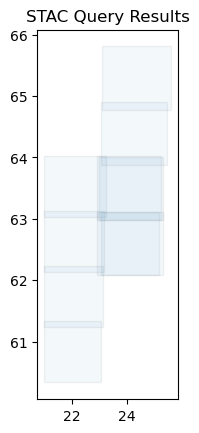

In [10]:
fig = gdf.plot(
    edgecolor="black",
    alpha=0.05,
)
_ = fig.set_title("STAC Query Results")

In [6]:
#daily.plot.imshow(row="time", rgb="band", robust=True, size=10)
#sentinel_stack.persist()
data.sel(band = 'B04_10m').squeeze().plot.imshow(col = "time",cmap = "viridis_r")

AttributeError: 'DatasetPlotAccessor' object has no attribute 'imshow'

In [24]:
sentinel_stack

<xarray.Dataset>
Dimensions:              (time: 10, y: 55970, x: 24461, band: 3)
Coordinates: (12/13)
  * time                 (time) datetime64[ns] 2023-07-02 ... 2023-07-02
    id                   (time) <U60 'S2A_MSIL2A_20230702T100601_N0509_R022_T...
  * x                    (x) float64 1.69e+05 1.69e+05 ... 4.351e+05 4.351e+05
  * y                    (y) float64 7.304e+06 7.304e+06 ... 6.695e+06 6.695e+06
    proj:epsg            (time) int64 32634 32634 32634 ... 32634 32635 32635
    eo:cloud_cover       (time) int64 63 88 56 52 85 84 71 77 85 84
    ...                   ...
    gsd                  (band) int64 10 10 20
    common_name          (band) object 'red' 'nir' None
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 3067
  * band                 (band) object 'B04_10m' 'B08_10m' 'SCL_20m'
Data variables:
    B04_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=3067, bounds=(168992.32786320036, 6695112...
    crs:            epsg:3067
    transform:      | 10.88, 0.00, 168992.33|\n| 0.00,-10.88, 7303806.00|\n| ...
    resolution_xy:  (10.880268340406925, 10.875345626963092)

In [19]:
daily.set_index(band = 'ndvi')

ValueError: dimension mismatch: try setting an index for dimension 'band' with variable 'ndvi' that has dimensions ('time', 'y', 'x')

In [16]:
daily

<xarray.Dataset>
Dimensions:              (time: 1, y: 55970, x: 24461, band: 2)
Coordinates:
  * x                    (x) float64 1.69e+05 1.69e+05 ... 4.351e+05 4.351e+05
  * y                    (y) float64 7.304e+06 7.304e+06 ... 6.695e+06 6.695e+06
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 3067
  * band                 (band) object 'B04_10m' 'B08_10m'
  * time                 (time) datetime64[ns] 2023-07-02
Data variables:
    B04_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ndvi                 (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=3067, bounds=(168992.32786320036, 6695112...
    crs:            epsg:3067
    transform:      | 10.88, 0.00, 168992.33|\n| 0.00,-10.88, 7303806.00|\n| ...
    resolution_xy:  (10.880268340406925, 10.875345626963092)

In [8]:
%%time
ndvi = (daily['B08_10m'] - daily['B04_10m'])/\
                        (daily['B08_10m'] + daily['B04_10m'])

output_file = os.path.join(outputpath, "NDVI_" + thisdate + ".tif")
print(output_file)

mean_ndvi_tiff = ndvi.isel(time=0).rio.to_raster(
    output_file,
    lock = Lock(name="rio"),
    tiled = True,
)

ndvi

/scratch/project_2013001/agriNDVI/NDVI2023/NDVI_2023-07-02.tif


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base

CPU times: user 1min 38s, sys: 5.53 s, total: 1min 43s
Wall time: 10min 22s


<xarray.DataArray (time: 1, y: 55970, x: 24461)>
dask.array<truediv, shape=(1, 55970, 24461), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x                    (x) float64 1.69e+05 1.69e+05 ... 4.351e+05 4.351e+05
  * y                    (y) float64 7.304e+06 7.304e+06 ... 6.695e+06 6.695e+06
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 3067
  * time                 (time) datetime64[ns] 2023-07-02

In [ ]:
# ehkä indeksejä voisi laskea spyndex kirjastolla:
# https://spyndex.readthedocs.io/en/latest/tutorials/pc.html

## Read tif

In [12]:
import rasterio


In [14]:
%%time
filepath = '/scratch/project_2013001/agriNDVI/NDVI2023/NDVI_2023-07-02.tif'

with rasterio.open(filepath) as src:
    #affine = src.affine # 'DatasetReader' object has no attribute 'affine'
    array = src.read()

stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})


print(stats)

[{'min': nan, 'mean': nan, 'median': nan, 'max': nan}]
CPU times: user 10.5 s, sys: 13.6 s, total: 24.1 s
Wall time: 23.1 s
